In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from tensorflow.python.client import device_lib
# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15263757692605937746
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11344216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 987021303046773177
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [21]:
"""
char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
total number of our output classes: len(char_list)
"""
char_list = string.ascii_letters+string.digits
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)       
    return dig_lst

In [22]:
path = '/content/gdrive/My Drive/tcs_new_data'
# lists for training dataset
"""
An example data that gets stored into the list is shown as comment in the side of the code below
"""

training_img = []           # training_img of shape (32, 128, 1) , image gets converted to its grey scale and normalised
training_txt = []           # training_txt = [28, 0, 19, 13, 0, 15, 15, 8, 13, 6] encoded form of the word
train_input_length = []     # train input length = 31
train_label_length = []     # train label length = 10 
orig_txt = []               # original word is 'Catnapping'
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0
 
i = 1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY) 
        # convert each image of shape (32, 128, 1)  by using padding
        w, h = img.shape
        if h > 128 or w > 32:
            """
            if height or width is greater than the input dimensions of the model then it should be ignored
            """
            continue
        if w < 32:
            """
            if width is less than 32, need to concatenate pixel positions with value 255,because in gray scale value 255
            represent white colur so padding with value 255 won't create issue in the image as a whole
            """
            add_zeros = np.ones((32-w, h))*255 
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            """
            if height is less than 128, need to concatenate pixel positions with value 255,because in gray scale value 255
            represent white colur so padding with value 255 won't create issue in the image as a whole
            """
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
            """
            Example for understanding how nxm dimension changes to nxmx1
            a 2x3 array is expanded to 2x3x1 for easiness of understanding
            array([[ 1,  2, 35],
                  [ 3,  4,  5]])
                -----> changes to
            array([[[ 1],
                    [ 2],
                    [35]],

                    [[ 3],
                    [ 4],
                    [ 5]]])
            """
        # Normalize each image
        img = img/255.
        
        # get the text from the image
        txt = f_name.split('_')[1]
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt) 
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        # break the loop if total data is 150000
        if i == 150000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break

link to the dataset https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth   

The sample of images that we are using is shown in the screenshot below. We are using 1,50,000 such images for building our model

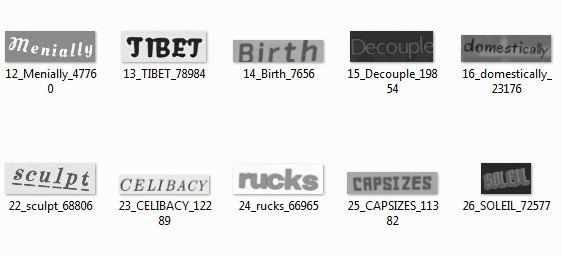

In [23]:
# pad each output label to maximum text length
 """
 Compute the maximum length from words and pad every output label to make it of the same size as the maximum length.
  This is done to make it compatible with the output shape of RNN architecture.
 """
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [24]:
"""
Model = CNN + RNN + CTC loss
Our model consists of three parts:
    The convolutional neural network to extract features from the image
    Recurrent neural network to predict sequential output per time-step
    CTC loss function which is transcription layer used to predict output for each time step.
"""
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
"""
Input shape for our architecture having an input image of height 32 and width 128.
"""

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
"""
Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). 
And the number of filters is increased from 64 to 512 layer by layer.

Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract
features with a larger width to predict long texts.

Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training process.
"""

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
"""
lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
""" 

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
"""
Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 63). 
Where 63 is the total number of output classes including blank character.
"""

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [25]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

In [26]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
"""
In preprocessing step we also need to create two other lists: one is label length and other 
is input length to our RNN. These two lists are important for our CTC loss .
Label length is the length of each output text label and input length is the same for each input
to the LSTM layer which is 31 in our architecture.
"""
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
"""
  A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels,
input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss 
function and then pass it to the model. To make it compatible with our model, we will create a model which
takes these four inputs and outputs the loss. This model will be used for training and for testing we will 
use the model that we have created earlier “act_model”. Let’s see the code:
"""
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [27]:
"""
for training the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save 
the weights of the best model on the basis of validation loss.
"""
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
filepath="tcs_jkj_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [28]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [29]:
batch_size = 256
epochs = 10
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length],
          y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, 
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length],
                             [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Train on 135000 samples, validate on 15000 samples
Epoch 1/10
135000/135000 [==============================] - 2910s 20ms/step - loss: 29.3684 - val_loss: 29.4565

Epoch 00001: val_loss improved from inf to 29.45648, saving model to tcs_jkj_model.hdf5
Epoch 2/10
135000/135000 [==============================] - 2745s 20ms/step - loss: 26.3215 - val_loss: 27.2546

Epoch 00002: val_loss improved from 29.45648 to 27.25462, saving model to tcs_jkj_model.hdf5
Epoch 3/10
135000/135000 [==============================] - 3121s 23ms/step - loss: 22.9325 - val_loss: 22.5686

Epoch 00003: val_loss improved from 27.25462 to 22.56858, saving model to tcs_jkj_model.hdf5
Epoch 4/10
135000/135000 [==============================] - 2945s 21ms/step - loss: 10.2332 - val_loss: 11.3642

Epoch 00004: val_loss improved from 22.56858 to 11.36422, saving model to tcs_jkj_model.hdf5
Epoch 5/10
135000/135000 [==============================] - 3019s 22ms/step - loss: 5.3127 - val_loss: 4.9421

Epoch 00005: val_lo

In [30]:
# load the saved best model weights
act_model.load_weights('/content/gdrive/My Drive/tcs_new_data/tcs_jkj_model.hdf5')

In [31]:
  """
Our model is now trained with 135000 images. We can not use our training
 model because it also requires labels as input and at test time we can not have labels. So to test the 
 model we will use ” act_model ” that we have created earlier which takes only one input: test images.

As our model predicts the probability for each class at each time step, we need to use some transcription 
function to convert it into actual texts. Here we will use the CTC decoder to get the output text.
"""
# predict outputs on validation images
prediction = act_model.predict(valid_img[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

original_text =   Champs
predicted text = Champs

original_text =   hokier
predicted text = hokier

original_text =   Cradling
predicted text = Crading

original_text =   KICKERS
predicted text = KICKERS

original_text =   shinier
predicted text = ShiNier

original_text =   stormed
predicted text = stormed

original_text =   EIGHTEENTH
predicted text = FrowTBs

original_text =   VERVE
predicted text = VERVE

original_text =   HEAL
predicted text = HEAL

original_text =   Theorize
predicted text = Theorize
    


The above output shows how our model predicts the alphabets in the images . We can see some issues in predictions over here. It can be further fine tunedand optimised. The prediction can be done little more accurate

**NOW WE ARE GOING TO TEST THE MODEL IN SOME REAL HAND WRITTEN DATA.I HAVE CREATED 6 IMAGES AND MADE WE ARE PROCESSING THE IMAGES TO IDENTIFY THE CHARACTERS IN THE IMAGE.**

In [32]:
# load the saved best model weights
act_model.load_weights('/content/gdrive/My Drive/tcs_new_data/tcs_jkj_model.hdf5')

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
test_file_list = []
path_to_files= os.path.join('/content/gdrive/My Drive/tcs_new_data/test','*')
for filename in sorted (glob.glob (path_to_files)):
    test_file_list.append(filename)

In [35]:
valid_img =[]
for i in test_file_list:
      img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2GRAY)   
      # convert each image of shape (32, 128, 1)
      w, h = img.shape
      if h > 128 or w > 32:
          print('failed')
          continue
      if w < 32:
          add_zeros = np.ones((32-w, h))*255
          img = np.concatenate((img, add_zeros))
      if h < 128:
          add_zeros = np.ones((32, 128-h))*255
          img = np.concatenate((img, add_zeros), axis=1)
      img = np.expand_dims(img , axis = 2)
      # Normalize each image
      img = img/255.
      valid_img.append(img)
valid_img = np.array(valid_img)

predicted text = Jyothiy

predicted text = Debashisroy

predicted text = TCSION

predicted text = Succesful

predicted text = Thankyou

predicted text = Verymuch



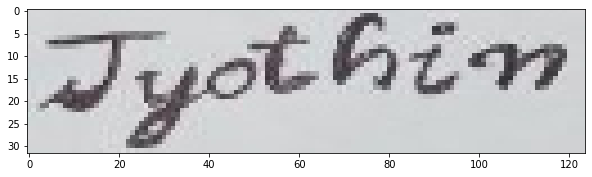

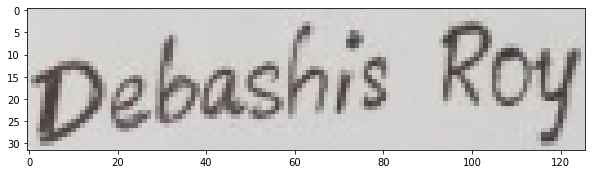

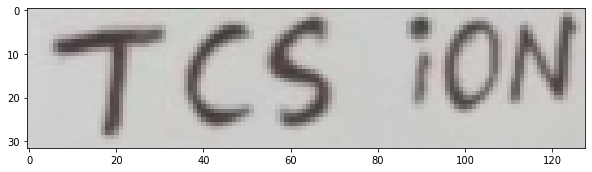

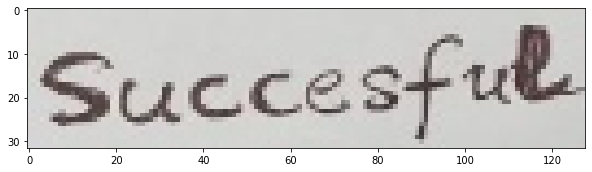

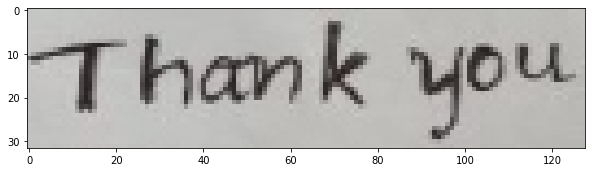

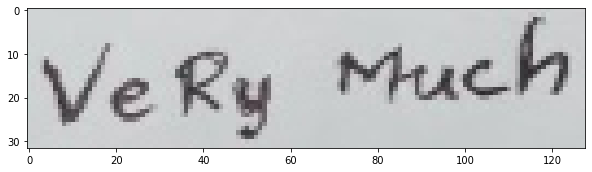

In [36]:
# predict outputs on validation images
prediction = act_model.predict(valid_img)
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])
# see the results
i = 0
for x in out:
    """below we can see the all predicted outputs and 
    we tried here to print the corresponding image along with it. 
    The matplotlib output is printed after the predicted text got printed """
    img = mpimg.imread(test_file_list[i])  
    plt.figure(figsize=(10,10))       
    plt.imshow(img,cmap='gray')
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

 ***We are now done with our project. We have created the model and tested that using handwritten images. The model is built on sythetic images which are more over kind of computer generated fonts. But the model worked well on handwritten images as well.. We can see that model couldn't identify the capital letters properly and space between them in some image like 'Very Much' , 'Thank You' , Since we haven't trained the model for identifying the white space between words and fine tuning the whole model. 
So as a further enhancement of the project we can include that as well while training and we can use handwritten images itself instead of synthetic data.***

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< **THANK YOU**>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>